# Training Random Forest Regression model for NOAAOffshoreWindProfiles-USA

* Creator(s): James Frech (1,2), Huai-Min Zhang (2)
* Affiliation(s):
    * 1. National Centers for Environmental Information ([NCEI](https://www.ncei.noaa.gov/)), National Oceanic and Atmospheric Administration (NOAA),
    * 2. Earth System Science Interdisciplinary Center (ESSIC), Cooperative Institute for Satellite Earth System Studies (CISESS), University of Maryland, College Park, MD, USA, 20740

---


## Overview
This notebook covers the process of training and validating the random forest regression (RFR) model used to generate the NOAA Offshore Wind Profiles - USA dataset. The random forest is a popular and powerful machine learning method that averages predictions over many decision trees to make a final ensemble prediction. The random forest in particular works well for regression and classification problems with nonlinear tabular data. More information on the model can be found online through many resources (simple: https://towardsdatascience.com/random-forest-regression-5f605132d19d/; original publication: https://www.stat.berkeley.edu/~breiman/randomforest2001.pdf). In this notebook, the random forest model is trained using cross validation to tune hyperparameters, tested at independent locations, and applied to new data to generate new wind profiles.

The problem that the NOAA Offshore Wind Profiles is designed to solve is the lack of available wind speeds around the rotor swept layer of wind turbines. This knowledge is important for being able to predict and forecast the power output of a given turbine. Many datasets contain surface wind speeds, including our surface NOAA Blended Seawinds (NBSv2), however these winds must be extrapolated vertically for optimal use in the offshore wind energy industry. There are a few tradition methods for this purpose, however, in recent years machine learning has shown to outperform these methods. This project seeks to make use of surface conditions (surface winds, air temperature, sea surface temperature) to extrapolate full vertical wind profiles up to 200 m. The surface wind speed is chosen as an input due to its obviously high correlation with the wind speeds in the wind profiles above, and the difference in air temperature and sea surface temperature is chosen as an input variable to provide an estimate of atmospheric stability which affects the shape of the vertical wind profiles. Our target variables are the wind speeds from 40 m to 200 m (20 m intervals).

### Prerequisites
Moderate knowledge of the python programming language is necessary for understanding this notebook. In addition experience in machine learning and knowledge of the RFR in particular would be very helpful for understanding the notebook. The NOAA Blended Seawinds notebook would also be helpful as an introduction for the dataset used to generate wind profiles in this notebook.

### Learning Outcomes
* Learn how to create and tune a random forest model.
* Use the multiprocessing module to run tasks in parallel.
* Apply the random forest model to generate new data.

### Time Estimate
* Estimated text reading time: 10 to 20 min
* Estimated code reading time: 10 to 20 min
* Estimated total reading time: 30 to 40 min
---



## Tutorial
The tutorial has four sections.
1. Tuning hyperparameters for the random forest regression model.
2. Training the final model with optimal parameters.
3. Applying the model to test data and checking model accuracy.
4. Implementing the model on the NOAA Blended Seawinds gridded dataset.

### Step 0: Install and import libraries

Before running the code, we must make sure our environment contains and imports the necessary python libraries

In [1]:
# import libraries and install them if necessary
import subprocess, sys
packages = ["pandas", "xarray","numpy","scikit-learn","matplotlib",
            "cartopy","itertools","tqdm","random"]
for package in packages:
    try:
        __import__(package)
    except ImportError:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', package])

In [2]:
# Import packages for notebook, taking just parts or using aliases
import pandas as pd
import xarray as xr
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm
import matplotlib.pyplot as plt
import itertools
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
from random import seed
import zipfile
import io
import requests

Set the random seed for reproducibility.  
Note: Results won't be exact in the end due to other packages not using this seed, but good practice anyways.

In [3]:
seed(1234)

### Step 1: Tuning Hyperparamters for the RFR

Tuning hyperparameters is an important task when creating any machine learning model as it affects the performance of the model. In the random forest, there are a few important hyperparameters to tune. The first is the number of trees in the model. If not enough trees are chosen to build the model, the model may not be complex enough to learn all the patterns in the data to create accurate predictions, in which case the model will be underfitting. The second parameter is the minimum number of samples to be considered at each split within the model. This parameter helps with regularization and stops the trees from growing too deep to avoid overfitting. Alternatively, the max depth of the trees can be tuned. Third, tuning the number of inputs allowed to be considered to create an optimal split will create more randomness in the model and ensures that the trees don't all build similarly only utilizing the most important features. This part of the tutorial will focus on tuning these parameters.

Before doing anything else, the data must be downloaded from zenodo. All data used in the notebook is stored in this Zenodo record (https://doi.org/10.5281/zenodo.15830540).

In [4]:
# Downloading the data from Zenodo record
url = 'https://zenodo.org/api/records/15830540/files-archive'
with zipfile.ZipFile(io.BytesIO(requests.get(url).content)) as zfile:
  zfile.extractall()

Read in the data here. The data provided consists of cleaned data from five different offshore floating lidar buoys: Hudson North, Hudson South, Hudson South West, Humboldt, and Morro Bay locations. The file contains columns for (1) the location of the data, (2) the time of the observation (10 minute resolution), (3) the surface wind speed at 10 m above sea level (w10), (4) the difference between surface air temperature and sea surface temperature, (5) the vertical wind speed profiles between 40 m and 200 m (w40, w60, ..., w200).

In [6]:
# Read training data with optimal input parameters and needed output columns
dat=pd.read_csv('training_data.csv')
dat

,location,time,w10,temp_diff,w40,w60,w80,w100,w120,w140,w160,w180,w200
0,Hudson South,2019-09-04 00:00:00,3.679043,-1.1400,3.8218,3.8193,3.8479,3.8223,3.8095,3.8747,3.9162,3.9656,4.0334
1,Hudson South,2019-09-04 00:10:00,3.727250,-1.1100,3.8689,3.8416,3.8418,3.8766,3.9057,3.9557,3.9679,4.0759,4.0526
2,Hudson South,2019-09-04 00:20:00,3.737587,-1.0900,3.9316,3.8941,3.9455,3.9555,4.0147,4.0512,4.0993,4.0715,4.1344
3,Hudson South,2019-09-04 00:30:00,3.680078,-1.0400,3.7904,3.8552,3.8465,3.8560,3.8717,3.8937,3.9033,3.9032,3.9683
4,Hudson South,2019-09-04 00:40:00,4.139271,-0.9900,4.2358,4.3596,4.3647,4.3550,4.3521,4.3278,4.3442,4.3641,4.4056
...,...,...,...,...,...,...,...,...,...,...,...,...,...
276572,Humboldt,2022-06-29 21:00:00,4.460659,-1.6405,3.1200,3.2500,3.3000,3.3900,3.3400,3.1800,2.9500,2.6800,2.5700
276573,Humboldt,2022-06-29 21:10:00,4.894301,-1.6430,3.6500,3.8300,3.9500,4.0200,3.9900,3.8600,3.6400,3.3700,3.2600
276574,Humboldt,2022-06-29 21:20:00,4.935618,-1.5585,3.7900,4.1600,4.3700,4.3800,4.3300,4.2000,3.9900,3.7700,3.5200
276575,Humboldt,2022-06-29 21:30:00,5.171281,-1.5140,3.7800,3.9800,4.0500,4.1400,4.1000,4.0500,3.9900,3.9200,3.7500


In [7]:
# Get names to keep track of which observation is from which dataset
places=['Hudson North','Hudson South West','Hudson South','Morro Bay','Humboldt']

# 5 locations, indices correspond to placement in "places" list above
location_indices = [0,1,2,3,4] 

In [8]:
# Pick the heights, inputs and targets for the model
heights=np.arange(40,220,20)
inputs=['w10','temp_diff']
targets=[f'w{h}' for h in heights]

Choose values for hyperparameters to try. Trying all combinations at all locations may take a while, so test it out on a few to start.

In [9]:
# Hyperparameter values to tune
n_estimators_values=[40,60,100,200,300]
min_samples_leaf_values=[20,30,40]
max_features_values=[1]
tasks=list(itertools.product(n_estimators_values, min_samples_leaf_values, max_features_values, location_indices))

Create a function to run the model with a given set of input parameters. The estimator, sample, and feature values are all hyperparameter combinations. The location index determines which location is held out as a validation set. Each station is held out individually while the model is trained on the other four locations to perform cross validation. Cross validation is a method used to ensure the optimal hyperparameter values are chosen. It computes the errors for each set of hyperparameters with the model trained on a different subset of training data. The hyperparameters that have the lowest average errors across all folds are then chosen. In this case, each station is held out separately as the model may not generalize well to certain locations and we need to make sure that the parameters we choose minimize the error everywhere.

Cross validation is an important process to creating a machine learning model. It ensures more robust performance allowing a given model to generalize well to unseen data and avoid overfitting. This is done by taking the average error over multiple different splits of the data, which makes sure the model isn't fitted against on section of the data on accident where it would perform worse on other data. Going further, cross validation plays an important part in geospatial data in particular. Different parts of the data come from different times and regions, which makes validating a model harder. One can't just train and validate a model at one location and expect it to work globally, nor can they train data from one summer in one specific year and expect it to work well in the winter of another. As such, splits for cross validation must be considered carefully. For time series data, it is important to train on past data, then validate against future data, or at least split up the time series into chunks. Randomly shuffling time series data can lead to overfitting as a model may learn to just fill the gaps in time as opposed to actual extrapolating the data. For geospatial data, it is also important make the training splits as different locations to show how robust a model is at extrapolating data across different regions.

For the purpose of this project, each split in cross validation is one of each five stations. In this way, we see how the model performs at locations distant to training data, and in addition we are not randomly taking out parts of the time series at all stations and filling in the gaps. If interesting, you can modify this code to make five randomly shuffled splits in the data not considering time or location. You will see that the model has higher performance! This is not necessarily a good thing. Performance on unseen data is what is important and randomly shuffling the data here can cause the model to not actually generalize well to locations other than these five. In addition, it will likely just be filling the gaps in the time series at each location and not actually learn to predict the profiles properly. In other words, the error metrics of the model obtained will not be representative of the errors you will get using the model on data elsewhere and make the model look better than it actually is.

Below we define a function to run the model given a set of hyperparameters and an index for each validation set. The function will split the data at the given index into a validation set, and combine the data at the other four locations into one training set. Run this for many hyperparameter combinations at each split to perform cross validation.

In [10]:
def run_model(estimator, sample, feature, location_idx):
    """
    Trains the random forest regressor model for a given set of hyperparameters on a selected location.

    Parameters
    ----------
    estimator : scalar(int)
        The total number of trees to use in the random forest.

    sample : scalar(int)
        The minimum number of samples per each leaf node required in the model.

    feature : scalar(int)
        The maximum number of features to consider for the optimal split in each split in the model.

    location_idx : scalar(int)
        Index corresponding to the location used as the validation set.

    Returns
    -------
    df : pd.DataFrame
        A pandas dataframe consisting of columns for the input parameters and the out of bag score and error.
    
    """
    # Initialize dataframe to store results
    df = pd.DataFrame([[estimator,sample,feature,places[location_idx]]],
                           columns=['n_estimators_values',
                                    'min_samples_leaf_values',
                                    'max_features_values',
                                    'location'])

    # Get train and validation data for given location and hyperparameters
    train=dat.loc[dat['location']!=places[location_idx]]
    val=dat.loc[dat['location']==places[location_idx]]

    # Initialize the random forest model
    rf=RandomForestRegressor(n_estimators=estimator,
                             min_samples_leaf=sample,
                             max_features=feature,
                             oob_score=True,
                             n_jobs=-1,
                             random_state=0)

    # Train random forest.
    rf.fit(train[inputs],train[targets])
    
    # Get OOB Score and OOB Error
    df['OOB Score'] = rf.oob_score_
    df['OOB Error'] = 1 - rf.oob_score_
    
    return(df)

Test the function to run the random forest model. After running you can see an issue with OOB error not calculating properly due to there not being enough trees in the model for accurate estimates.

In [11]:
# Test the model with one combination
example = run_model(20,50,1,0)
example

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


,n_estimators_values,min_samples_leaf_values,max_features_values,location,OOB Score,OOB Error
0,20,50,1,Hudson North,0.943946,0.056054


Run the model for all hyperparameter combinations. For loop is slow. Prefer using multiprocessing code below.

In [12]:
results = pd.DataFrame()
for task in tqdm(tasks):
    results = pd.concat([results,run_model(task[0],task[1],task[2],task[3])])
print(results)

100%|██████████| 75/75 [25:11<00:00, 20.16s/it]

    n_estimators_values  min_samples_leaf_values  max_features_values  \
0                    40                       20                    1   
0                    40                       20                    1   
0                    40                       20                    1   
0                    40                       20                    1   
0                    40                       20                    1   
..                  ...                      ...                  ...   
0                   300                       40                    1   
0                   300                       40                    1   
0                   300                       40                    1   
0                   300                       40                    1   
0                   300                       40                    1   

             location  OOB Score  OOB Error  
0        Hudson North   0.945496   0.054504  
0   Hudson South West   0.94985

This took 17 minutes to run. With multiprocess using 6 parallel threads, this could have been 3 minutes!

The code below works for running with multiprocessing, but may have issues in notebooks. As such a for loop is used above for demonstration. n different combinations of hyperparameters will run simultaneously and a new one will start each when one finishes.  

    from multiprocessing import set_start_method
    from multiprocessing import Pool
    
    n=6
    if __name__ == '__main__':  
        with Pool(processes=n) as pool:  
            set_start_method("spawn",force=True)  
            # Run all the combinations of hyperparameters and save the output dataframes  
            model_dfs=pool.starmap(run_model, tasks)  
    # Concatenate all the output dataframes to lists  
    metrics_df=pd.concat(model_dfs)  
    metrics_df  

In addition, sklearn has its own built in cross validation methods (GridSearchCV, RandomizedSearchCV) with different types of kfold validation https://scikit-learn.org/stable/api/sklearn.model_selection.html. These could be used as well. The folds in this case are the 5 stations (5 fold CV). This notebook uses a grid search cross validation where every combination of parameters in the grid is tested. Randomized search would randomly sample different combinations of hyperparameters to use without trying all of them. This is sometimes done to reduce the amount of time needed to tune the parameters.

Plot the results

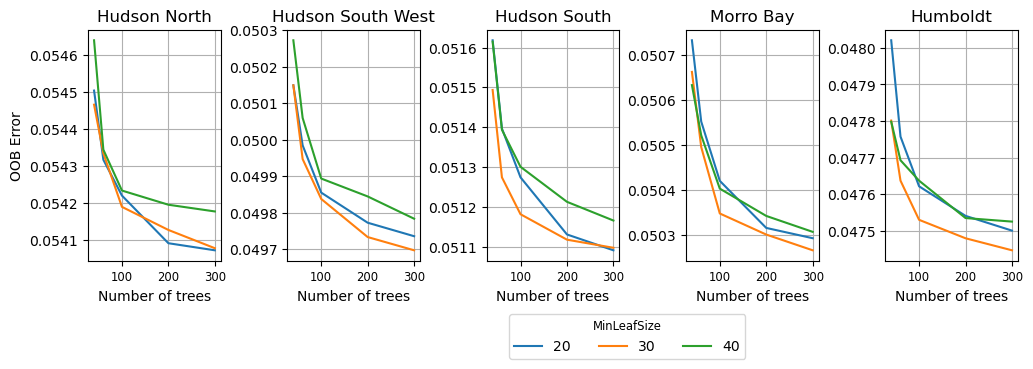

In [13]:
fig,axs=plt.subplots(nrows=1,ncols=5,figsize=(12,3))
for i in range(5):
    data_loc = results.loc[results['location']==places[i]]

    for j,leaves in enumerate(min_samples_leaf_values):
        dat_lf=data_loc.loc[data_loc['min_samples_leaf_values']==leaves]
        axs[i].plot(dat_lf['n_estimators_values'],dat_lf['OOB Error'],label=leaves)
    if i==0:
        axs[i].set_ylabel('OOB Error')
    axs[i].set_title(places[i])
    axs[i].set_xlabel('Number of trees')
    axs[i].xaxis.set_tick_params(labelsize='small')    
    axs[i].grid()
axs[2].legend(bbox_to_anchor=(2,-.2),title='MinLeafSize',title_fontsize='small',ncol=len(min_samples_leaf_values))
plt.subplots_adjust(wspace=.5)


The hyperparameters that should be chosen are the ones that minimize the error. For number of trees, there is a point where the error no longer decreases and flattens. Choose one of the first values that minimize the error, so both the error is minimized, and number of trees used isn't excessive. With full results, this turned out to be around 1000. For minimum samples per leaf, choose the line that is lowest. We found 30 in our results. With more than two inputs, it helps to also tune the number of features available for each split ("max_features").  
  
The results here show that the optimal hyperparameters stay the same regardless of which location is held out from the training data.

### Step 2: Train the model with optimal parameters.

Create the final model with optimal parameters. Use data from all training stations this time.

In [14]:
# Use optimal parameters from our paper
rf=RandomForestRegressor(n_estimators=1000,
                         min_samples_leaf=30,
                         max_features=1,
                         oob_score=True,
                         n_jobs=-1,
                         random_state=0)

# Train random forest.
rf.fit(dat[inputs],dat[targets])

RandomForestRegressor(max_features=1, min_samples_leaf=30, n_estimators=1000,
                      n_jobs=-1, oob_score=True, random_state=0)

### Step 3: Check the model accuracy at testing locations - Atlantic Shores

While the model seems to work well on the training data, accuracy needs to further be assessed on independent training data to make sure the model isn't overfitting to the training data. In this case, a lidar station at a location independent of all training data is used as a test dataset to make sure the model generalizes well to locations other than the training data. 

Read in test dataset

In [15]:
asow=pd.read_csv('AtlanticShores4_cleaned.csv')
asow['temp_diff']=asow['air_temp']-asow['SST']

Predict the wind speed profiles

In [16]:
asow[[f'w{h}_pred' for h in heights]] = rf.predict(asow[['w10','temp_diff']])
asow

,time,air_temp,SST,w10,w40,w60,w80,w100,w120,w140,...,temp_diff,w40_pred,w60_pred,w80_pred,w100_pred,w120_pred,w140_pred,w160_pred,w180_pred,w200_pred
0,2021-05-14 16:30:00,14.00391,13.82178,2.57422,2.52954,2.64124,2.61890,2.67102,2.87952,2.72314,...,0.18213,3.202995,3.436669,3.607690,3.750191,3.894891,4.031077,4.156238,4.273528,4.390401
1,2021-05-14 16:40:00,14.11133,13.84229,2.48486,2.44763,2.45508,2.53699,2.86462,2.93164,2.75293,...,0.26904,3.300581,3.687703,3.978933,4.229158,4.465177,4.675429,4.868366,5.045922,5.203589
2,2021-05-14 16:50:00,14.16504,13.87305,2.26147,2.28381,2.33594,2.63379,3.13269,3.26672,2.98376,...,0.29199,2.970773,3.294819,3.548855,3.754991,3.949965,4.127610,4.295326,4.454996,4.607855
3,2021-05-14 17:00:00,14.21875,13.92432,2.05298,2.00085,2.22424,2.58911,3.08057,2.95398,2.82739,...,0.29443,2.771960,3.091511,3.370940,3.609623,3.854418,4.082239,4.300752,4.485152,4.677612
4,2021-05-14 17:10:00,14.32617,14.00635,1.90405,2.06787,2.24658,2.67847,3.11780,3.03589,3.02100,...,0.31982,2.378450,2.560306,2.745461,2.938255,3.147448,3.350747,3.557519,3.760784,3.988345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14526,2021-09-30 11:00:00,18.62305,21.18408,6.62500,7.01965,7.15369,7.01221,6.98242,6.94519,7.33984,...,-2.56103,6.853582,6.928769,6.981764,7.020855,7.078331,7.112477,7.154793,7.191700,7.235197
14527,2021-09-30 11:10:00,18.73047,21.18408,6.32715,6.52075,7.10901,7.12390,7.33240,7.25793,6.98242,...,-2.45361,6.513777,6.596303,6.649153,6.672806,6.691013,6.692535,6.670843,6.659621,6.678562
14528,2021-09-30 11:20:00,18.62305,21.19434,5.01660,6.34949,6.47607,6.62500,6.61011,6.72925,6.69202,...,-2.57129,5.223161,5.293555,5.346480,5.392743,5.441021,5.483677,5.522090,5.577330,5.618545
14529,2021-09-30 11:30:00,18.99902,20.60986,4.45068,6.17822,6.46118,6.28992,6.53564,6.53564,6.83350,...,-1.61084,4.548341,4.599918,4.626269,4.624768,4.640347,4.646031,4.653937,4.679275,4.737834


Plot results

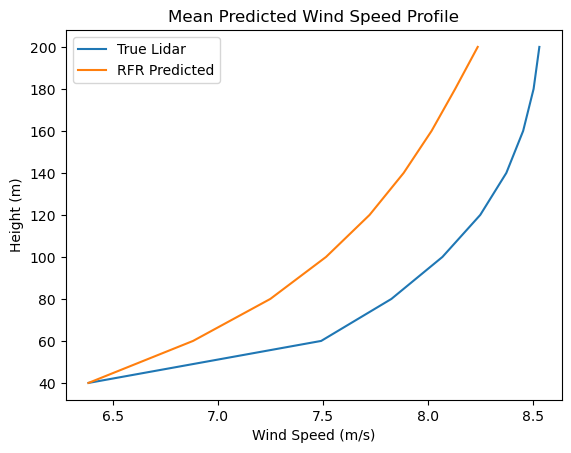

In [17]:
plt.plot(asow[[f'w{h}' for h in heights]].mean(),heights,label='True Lidar')
plt.plot(asow[[f'w{h}_pred' for h in heights]].mean(),heights,label='RFR Predicted')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Height (m)')
plt.title('Mean Predicted Wind Speed Profile')
plt.legend()

Compute error metrics. Bias and mean absolute error (MAE) are used here as they are common for regression problems. The bias is the statistical bias of the model, which shows if a model is underpredicting (negative) or overpredicting (positive) on average. A value of 0 is desirable and shows a model has no bias. MAE is the average difference between the prediction and true value. This shows how much you can expect your model to be off in its prediction on average.

bias = $\frac{\sum_{i=1}^{n} \hat{y_i} - y_i}{n}$ 

MAE = $\frac{\sum_{i=1}^{n} |\hat{y_i} - y_i|}{n}$

where $y$ is the true value, $\hat{y}$ is the prediction, and $n$ is the total number of observations.

Side Note: These metrics are meant for regression problems. If using the random forest for a classification problem, other metrics (ROC AUC, precision, recall, F1) should be chosen. In addition, the sklearn RandomForestClassifier should be chosen instead of RandomForestRegressor.

In [18]:
bias = (asow[[f'w{h}_pred' for h in heights]] - asow[[f'w{h}' for h in heights]].values).mean()
mae = (asow[[f'w{h}_pred' for h in heights]] - asow[[f'w{h}' for h in heights]].values).abs().mean()

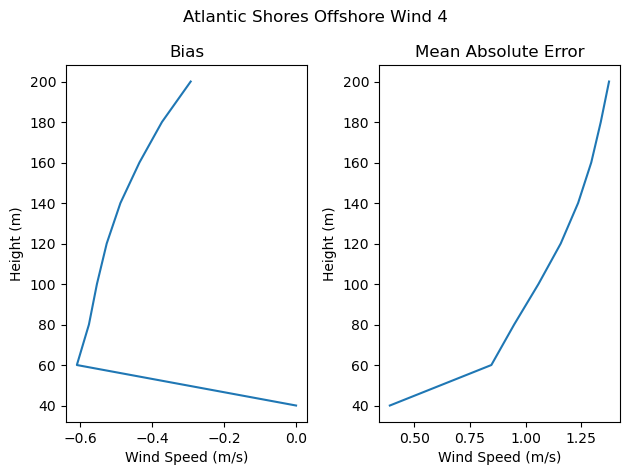

In [19]:
fig, axs = plt.subplots(ncols=2)
plt.suptitle('Atlantic Shores Offshore Wind 4')
axs[0].plot(bias,heights)
axs[0].set_xlabel('Wind Speed (m/s)')
axs[0].set_ylabel('Height (m)')
axs[0].set_title('Bias')

axs[1].plot(mae,heights)
axs[1].set_xlabel('Wind Speed (m/s)')
axs[1].set_ylabel('Height (m)')
axs[1].set_title('Mean Absolute Error')

plt.tight_layout()

Looking into the profiles of the errors, it is clear in the MAE that the model has increasing errors with height. This is unsurprising due to the surface variables having higher correlations with the wind speeds at the lower heights. It can also be seen that the model is underestimating the wind speeds on average throughout the profiles due to the negative bias. Interestingly, the model is almost completely unbiased at 40 m, then goes to relatively higher bias at 60 m, then gradually decreases with height. This can also be seen in the above plot with the average wind speed profile where the average is almost excatly the same at 40 m, however the model is predicting lower wind speeds above, yet gradually gets slightly close to the truth as height increases. Judging by these results, it seems the data at the praticular test site has higher wind shear compared to most of the training stations. However, this is just one test location and results could vary somewhat depending on where the analysis is done. Regardless, the errors are still within an acceptable range.

While error metrics are only computed here on the test data, it makes sense to also compute these errors for held out stations in cross validation to ensure the model was able to accurately predict profiles at each location and doesn't have any issues at any particular location.

### Step 4: Implement the model on NOAA Blended Seawinds (NBSv2)

Now that the model is created and an error assessment is made, the model can be applied to new data. The objective here is to create a fully gridded map of offshore wind profiles. As such, we need our input variables (surface wind speed, air - sea temperature difference) on the same gridded resolution. Here we use surface winds from the Blended Seawinds, and take the difference between the air temperature at 2 m and sea surface temperature from ERA5 analysis, both on a 0.25 degree global grid as input into the model. Using these datasets allow us to use the surface wind and air - sea tempearture difference at each grid point, and extrapolate the vertical wind profile. This is done for each time step at each grid point. 

Read in a Blended Seawinds file. The code displayed here downloads NBSv2 from the NOAA Coastwatch Server. For demonstration purposes, use the file provided with the notebook.

    year, month, day = 2024, 12, 12 # Pick a day
    
    # Get URL for 6 hourly NBS data
    base_url='https://www.star.nesdis.noaa.gov/thredds/dodsC/uvcompNCEIBlendedGlobalSCISixHourWW00'
    filename=f"{base_url}/{year}/NBSv02_wind_6hourly_{year}{month}{day}.nc"
    
    # Open File
    nbs = xr.open_dataset(filename)
    nbs

In [20]:
year, month, day = 2024, 12, 12 # Pick a day

filename=f"NBSv02_wind_6hourly_{year}{month}{day}.nc"

# Open File
nbs = xr.open_dataset(filename)

# Get magnitude of wind speed
nbs['w10']=(nbs['u_wind']**2+nbs['v_wind']**2)**0.5
# Select spatial bounds (lon is 0 to 360 in NBS)
nbs=nbs.isel(lon=(nbs.lon>=190)&(nbs.lon<=310),lat=(nbs.lat>=15)&(nbs.lat<=71.5))
# Convert to pandas dataferame
nbs=nbs.to_dataframe().reset_index()
# Drop zlev as it is unnecessary for this analysis
nbs=nbs.drop('zlev',axis=1)
nbs

,time,lat,lon,crs,mask,u_wind,v_wind,w10
0,2024-12-12 00:00:00,15.0,190.00,-9999.0,1.0,-10.592870,-1.297211,10.672003
1,2024-12-12 00:00:00,15.0,190.25,-9999.0,1.0,-10.508510,-1.385846,10.599497
2,2024-12-12 00:00:00,15.0,190.50,-9999.0,1.0,-10.455713,-1.541452,10.568728
3,2024-12-12 00:00:00,15.0,190.75,-9999.0,1.0,-10.440518,-1.749787,10.586131
4,2024-12-12 00:00:00,15.0,191.00,-9999.0,1.0,-10.448401,-1.973764,10.633195
...,...,...,...,...,...,...,...,...
436743,2024-12-12 18:00:00,71.5,309.00,-9999.0,0.0,NaN,NaN,NaN
436744,2024-12-12 18:00:00,71.5,309.25,-9999.0,0.0,NaN,NaN,NaN
436745,2024-12-12 18:00:00,71.5,309.50,-9999.0,0.0,NaN,NaN,NaN
436746,2024-12-12 18:00:00,71.5,309.75,-9999.0,0.0,NaN,NaN,NaN


Read in ERA5 air temperature and sea surface temperature.  
Note: You need to have an account for API access to ERA5 data to download more than the sample file.  
The dataset is found here: https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels?tab=download#manage-licences

In [21]:
era=xr.open_dataset(f'era5_{year}{month}{day}.nc')
era=era.sel(valid_time=era['valid_time'].isin(nbs['time'])) # Make sure time variable matches up
era['temp_diff']=era['t2m']-era['sst'] # Calculate temperature difference for model input
era=era.rename({'latitude':'lat','longitude':'lon','valid_time':'time'}) # Rename variables to match NBS
era.coords['lon'] = (era.coords['lon'] + 180) % 360 + 180 # Convert longitude to match NBS
era=era.isel(lon=(era.lon>=190)&(era.lon<=310),lat=(era.lat>=15)&(era.lat<=71.5)) # Get spatial bounds
era=era.to_dataframe().reset_index()
era

,time,lat,lon,number,expver,t2m,sst,temp_diff
0,2024-12-12 00:00:00,71.5,190.00,0,0005,266.309509,271.459717,-5.150208
1,2024-12-12 00:00:00,71.5,190.25,0,0005,266.256775,271.459717,-5.202942
2,2024-12-12 00:00:00,71.5,190.50,0,0005,266.219666,271.459717,-5.240051
3,2024-12-12 00:00:00,71.5,190.75,0,0005,266.182556,271.459717,-5.277161
4,2024-12-12 00:00:00,71.5,191.00,0,0005,266.172791,271.459717,-5.286926
...,...,...,...,...,...,...,...,...
436743,2024-12-12 18:00:00,15.0,309.00,0,0005,297.999847,300.692139,-2.692291
436744,2024-12-12 18:00:00,15.0,309.25,0,0005,298.113129,300.663818,-2.550690
436745,2024-12-12 18:00:00,15.0,309.50,0,0005,298.361176,300.710693,-2.349518
436746,2024-12-12 18:00:00,15.0,309.75,0,0005,299.017426,300.783936,-1.766510


Merge the two datasets and use the model to predict wind speed profiles using the input surface wind speed (w10) and surface air - sea temperature difference (temp_diff).

In [22]:
# Merge the NBS and ERA datasets
dat=pd.merge(nbs,era,on=['time','lat','lon'],how='left')
dat=dat.dropna(subset=['w10','temp_diff']).reset_index(drop=True) # remove any missing values

# Predict the wind speed profiles
heights = [40,60,80,100,120,140,160,180,200]
dat[[f'w{h}' for h in heights]]=rf.predict(dat[['w10','temp_diff']])

Plot out the generated wind profiles for one time step. Each subplot contains a different vertical layer of the profiles denoted by w{h} where h is the height in m above the surface. W10 corresponds to the surface wind speed inputs from NBSv2. All the rest of the subplots shown are actual model predictions for the wind speed at each height. Looking at the plots, it is clear the wind speed is increasing at many locations, and areas of higher wind are more prominently shown at higher heights.

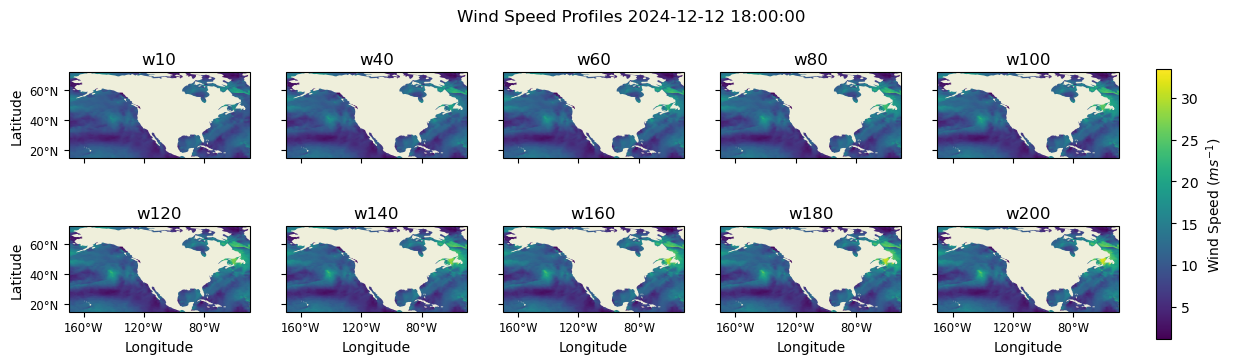

In [23]:
dat = dat.loc[dat['time'].dt.hour==18]

crs = ccrs.PlateCarree() # Coordinate referencing system for plot
heights = [10,40,60,80,100,120,140,160,180,200]
maxval=dat[[f'w{h}' for h in heights]].max().max() # Max wind speed across all heights

# Initialize figure and subplots
fig,axs=plt.subplots(nrows=2,ncols=5, subplot_kw={'projection':crs},figsize=(15,6))
plt.suptitle(f"Wind Speed Profiles {year}-{month}-{day} 18:00:00",y=.8)
k=0
for i in range(2):
    for j in range(5):
        axs[i,j].set_extent([dat['lon'].min(),dat['lon'].max(),dat['lat'].min(),dat['lat'].max()],crs=crs)
        im=axs[i,j].scatter(dat['lon'],dat['lat'],c=dat[f'w{heights[k]}'],marker='s',s=.5,vmax=maxval)
        axs[i,j].add_feature(cfeature.LAND,zorder=2)
        
        # Title and label axes
        axs[i,j].set_title(f'w{heights[k]}')
        if i==1:
            axs[i,j].set_xlabel('Longitude')
        if j==0:
            axs[i,j].set_ylabel('Latitude')

        # Add x,y ticks
        axs[i,j].tick_params(axis='both',labelsize='small')
        axs[i,j].yaxis.set_major_formatter(cticker.LatitudeFormatter())
        axs[i,j].xaxis.set_major_formatter(cticker.LongitudeFormatter())
        axs[i,j].set_yticks([20,40,60],crs=crs)
        axs[i,j].set_xticks([-160,-120,-80],crs=crs)
        if i!=1:
            axs[i,j].set_xticklabels([])
        if j!=0:
            axs[i,j].set_yticklabels([])

        k+=1 # Increment to next height for next plot

# Make adjustments to the plot and add in axes for the colorbar
plt.subplots_adjust(hspace=-.5,right=0.825)
cbar_ax = fig.add_axes([0.85, 0.25, 0.01, 0.45])
# add colorbar
cbar = plt.colorbar(im, cax=cbar_ax)
cbar.set_label('Wind Speed ($m s^{-1}$)')

plt.show()

Now that we have wind profiles, we can generate wind power metrics around the US coasts at many heights. A useful wind energy metric is the wind power density, which gives a measure of how many watts per square meter a turbine would generate. Wind power density is formulated as:

WPD = 0.5$\rho$$w^3$

where $\rho$ is the surface air density assumed to be 1.225 $kg$ $m^{-3}$ and $w$ is the wind speed ($m$ $s^{-1}$).

Formulations for wind power density and other wind energy metrics can be found in "A Positive Climatic Trend in the Global Offshore Wind Power" https://www.frontiersin.org/journals/energy-research/articles/10.3389/fenrg.2022.867642/full.

Using this formula, we can plot the wind power density as well, just as we plotted the wind speed above.

In [24]:
# Calculate wind power density
dat[[f'wpd{h}' for h in heights]] = 0.5*1.225*dat[[f'w{h}' for h in heights]]**3

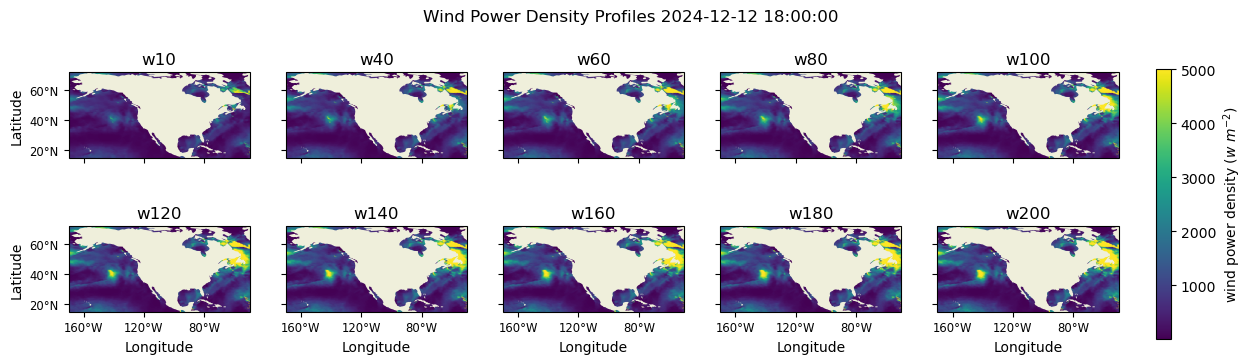

In [25]:
crs = ccrs.PlateCarree() # Coordinate referencing system for plot
maxval=dat[[f'wpd{h}' for h in heights]].max().max() # Max wind speed across all heights
maxval = 5000

# Initialize figure and subplots
fig,axs=plt.subplots(nrows=2,ncols=5, subplot_kw={'projection':crs},figsize=(15,6))
plt.suptitle(f'Wind Power Density Profiles {year}-{month}-{day} 18:00:00',y=.8)

k=0
for i in range(2):
    for j in range(5):
        axs[i,j].set_extent([dat['lon'].min(),dat['lon'].max(),dat['lat'].min(),dat['lat'].max()],crs=crs)
        im=axs[i,j].scatter(dat['lon'],dat['lat'],c=dat[f'wpd{heights[k]}'],marker='s',s=.5,vmax=maxval)
        axs[i,j].add_feature(cfeature.LAND,zorder=2)
        
        # Title and label axes
        axs[i,j].set_title(f'w{heights[k]}')
        if i==1:
            axs[i,j].set_xlabel('Longitude')
        if j==0:
            axs[i,j].set_ylabel('Latitude')

        # Add x,y ticks
        axs[i,j].tick_params(axis='both',labelsize='small')
        axs[i,j].yaxis.set_major_formatter(cticker.LatitudeFormatter())
        axs[i,j].xaxis.set_major_formatter(cticker.LongitudeFormatter())
        axs[i,j].set_yticks([20,40,60],crs=crs)
        axs[i,j].set_xticks([-160,-120,-80],crs=crs)
        if i!=1:
            axs[i,j].set_xticklabels([])
        if j!=0:
            axs[i,j].set_yticklabels([])

        k+=1 # Increment to next height for next plot

# Make adjustments to the plot and add in axes for the colorbar
plt.subplots_adjust(hspace=-.5,right=0.825)
cbar_ax = fig.add_axes([0.85, 0.25, 0.01, 0.45])
# add colorbar
fig.colorbar(im, cax=cbar_ax,label='wind power density ($w$ $m^{-2}$)')

plt.show()



---


## Exercises

1. Using the data above, test around with different combinations of hyperparameters for the random forest model to see if you can find values that further minimize the error.
2. Try using the multiprocessing module to run the hyperparameter tuning in parallel jobs.
3. Read through documentation for sklearn's implementations of cross validation in the model selection module https://scikit-learn.org/stable/api/sklearn.model_selection.html. See if you can get similar results using sklearn. In addition, feel free to calculate different error metrics from sklearn's metrics module https://scikit-learn.org/1.5/api/sklearn.metrics.html. These can be used as criteria for cross validation in place of OOB score.
4. Use the model on a new dataset of your choice to solve a regression problem.

## Next steps
There are no more notebooks to follow this one.

## Examples in NOAA

The random forest in this notebook is used to generate the NOAA Offshore Wind Profiles - USA product.

## Data statement
The data used in this notebook can be accessed from the following sources.

Gridded Data
* NOAA Blended Seawinds (NBSv2.0)
    * https://coastwatch.noaa.gov/cwn/products/noaa-ncei-blended-seawinds-nbs-v2.html
* ECMWF Reanlysis (ERA5)
    * https://doi.org/10.24381/cds.adbb2d47
* The model created is used to generate the NOAA Offshore Wind Profiles - USA product which will be made publicly available.

Training data
* Hudson North, Hudson South, and Hudson South West
    * https://catalog.data.gov/dataset/floating-lidar-buoy-data-beginning-august-2019/resource/92917d13-5728-4edf-828c-a45b3d1a99c3
* Morro Bay
    * https://doi.org/10.21947/1959715
    * https://doi.org/10.21947/1959720
* Humboldt
    * https://doi.org/10.21947/1959713
    * https://doi.org/10.21947/1959719
 
Test data
* Atlantic Shores Offshore Wind 4
    * https://erddap.maracoos.org/erddap/tabledap/AtlanticShores_ASOW-4_wind.html
    * https://erddap.maracoos.org/erddap/tabledap/AtlanticShores_ASOW-4_timeseries.htmlble.

* Acknowledgements:
    * A chunk of funding support was provided by the NCAI DAD Pilot Project.

## References

Frech, J., Saha, K., Lavin, P. D., Zhang, H.-M., Reagan, J., and Fung, B.: A New Gridded Offshore Wind Profile Product for US Coasts Using Machine Learning and Satellite Observations, Wind Energ. Sci. Discuss. [preprint], https://doi.org/10.5194/wes-2024-77, in review, 2024.

Saha K and Zhang H-M (2022) Hurricane and Typhoon Storm Wind Resolving NOAA NCEI Blended Sea Surface Wind (NBS) Product. Front. Mar. Sci. 9:935549. doi: 10.3389/fmars.2022.935549

Zheng C-w, Yi C-t, Shen C, Yu D-c, Wang X-l, Wang Y, Zhang W-k, Wei Y, Chen Y-g, Li W, Jin X, Jia S-d, Wu D, Wei D-j, Zhao X-f, Tian Y-y, Zhou W and Xiao Z-n (2022) A Positive Climatic Trend in the Global Offshore Wind Power. Front. Energy Res. 10:867642. doi: 10.3389/fenrg.2022.867642

## Metadata
 * Language / package(s): python: sklearn, numpy, pandas, matplotlib, cartopy
 * Application keywords: wind energy
 * Geophysical keywords: offshore wind, wind, air-sea interaction 
 * AI keywords: machine learning, random forest, regression, cross validation

## Disclaimer
This Jupyter notebook is a scientific product and is not official communication of the National Oceanic and Atmospheric Administration, or the United States Department of Commerce. All NOAA Jupyter notebooks are provided on an 'as is' basis and the user assumes responsibility for its use. Any claims against the Department of Commerce or Department of Commerce bureaus stemming from the use of this Jupyter notebook will be governed by all applicable Federal law. Any reference to specific commercial products, processes, or services by service mark, trademark, manufacturer, or otherwise does not constitute or imply their endorsement, recommendation or favoring by the Department of Commerce. The Department of Commerce seal and logo, or the seal and logo of a DOC bureau, shall not be used in any manner to imply endorsement of any commercial product or activity by DOC or the United States Government.